In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# %matplotlib notebook
%matplotlib inline
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm, tqdm_notebook


In [328]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score, precision_recall_curve, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, StratifiedShuffleSplit

Import radiology features

In [ ]:
df_radio = pd.read_csv("data/features_radiology.csv")
df_radio = df_radio.set_index(["ids", "subids"])

In [44]:
df_radio.head()

feat_radio_0  feat_radio_1  feat_radio_10  feat_radio_11  \
ids subids                                                             
2   0           0.109204      0.001364       0.004211       0.079439   
    1           0.106394      0.000984       0.006510       0.075854   
    2           0.108518      0.000734       0.005787       0.080568   
    3           0.100031      0.000607       0.004356       0.088266   
    4           0.111571      0.001089       0.004684       0.082056   

            feat_radio_12  feat_radio_13  feat_radio_14  feat_radio_15  \
ids subids                                                               
2   0            0.004499       0.014230       0.107824       0.016840   
    1            0.004192       0.012545       0.100865       0.014072   
    2            0.003764       0.012268       0.093632       0.016102   
    3            0.003243       0.012753       0.095362       0.015207   
    4            0.005700       0.013753       0.100201       0.014841   

            feat_radio_16  feat_radio_17  ...    feat_radio_59  feat_radio_6  \
ids subids                                ...                                  
2   0            0.001605       0.079541  ...         0.002742      0.098998   
    1            0.001394       0.070136  ...         0.002030      0.103357   
    2            0.000914       0.081330  ...         0.002069      0.096785   
    3            0.001268       0.074467  ...         0.002532      0.112659   
    4            0.000774       0.072015  ...         0.002970      0.095807   

            feat_radio_60  feat_radio_61  feat_radio_62  feat_radio_63  \
ids subids                                                               
2   0            0.030836       0.114170       0.082824       0.001789   
    1            0.032089       0.098909       0.071703       0.001326   
    2            0.034676       0.106771       0.083527       0.000824   
    3            0.025957       0.101485       0.080971       0.001574   
    4            0.033097       0.123157       0.075025       0.000908   

            feat_radio_7  feat_radio_8  feat_radio_9  ytrue  
ids subids                                                   
2   0           0.035611      0.001589      0.084844    1.0  
    1           0.043425      0.000866      0.076407    1.0  
    2           0.034718      0.001417      0.072300    1.0  
    3           0.039907      0.002054      0.072023    1.0  
    4           0.045189      0.001885      0.067061    1.0  

[5 rows x 65 columns]

Import pathology features

In [36]:
def preproc_patho(i):
    df = pd.read_csv("../miccai-pathology/pathology_features_{}.csv".format(i))
    df.columns = ["ids"] + ["feat_patho_" + str(i) for i in range(100)]
    df["ids"] = [int(x.split("_")[-1]) for x in df.ids]
    df["subids"] = i
    return df.set_index(["ids", "subids"])

In [37]:
df_patho = pd.concat([preproc_patho(i) for i in range(10)]).sort_index()

In [43]:
df_patho.head()

feat_patho_0  feat_patho_1  feat_patho_2  feat_patho_3  \
ids subids                                                           
1   0           0.075402      0.034955      0.009047      0.080909   
    1           0.074703      0.035082      0.008864      0.080585   
    2           0.078055      0.036504      0.008836      0.080029   
    3           0.077085      0.034677      0.009039      0.078584   
    4           0.075745      0.036287      0.009012      0.081278   

            feat_patho_4  feat_patho_5  feat_patho_6  feat_patho_7  \
ids subids                                                           
1   0           0.086850      0.178829      0.005007      0.180438   
    1           0.087096      0.175073      0.005057      0.179167   
    2           0.086552      0.167815      0.005189      0.174643   
    3           0.086590      0.166312      0.005370      0.178229   
    4           0.085925      0.174302      0.005171      0.178550   

            feat_patho_8  feat_patho_9      ...        feat_patho_90  \
ids subids                                  ...                        
1   0           0.047991      0.260377      ...             0.004630   
    1           0.048033      0.261853      ...             0.005010   
    2           0.046244      0.266628      ...             0.004570   
    3           0.046570      0.268023      ...             0.005266   
    4           0.045496      0.263243      ...             0.004740   

            feat_patho_91  feat_patho_92  feat_patho_93  feat_patho_94  \
ids subids                                                               
1   0            0.080844       0.042112       0.399136       0.029377   
    1            0.081317       0.039131       0.402078       0.028915   
    2            0.083331       0.042091       0.404100       0.029832   
    3            0.083153       0.040811       0.397544       0.028980   
    4            0.083155       0.043377       0.403894       0.030265   

            feat_patho_95  feat_patho_96  feat_patho_97  feat_patho_98  \
ids subids                                                               
1   0            0.008482       0.160810       0.116687       0.100522   
    1            0.008040       0.160821       0.115942       0.101294   
    2            0.008408       0.159643       0.118677       0.102330   
    3            0.008847       0.157928       0.118773       0.101687   
    4            0.008334       0.162132       0.116826       0.099603   

            feat_patho_99  
ids subids                 
1   0            0.079040  
    1            0.081068  
    2            0.080426  
    3            0.081735  
    4            0.078927  

[5 rows x 100 columns]

Combine them

In [369]:
df_combined = df_radio.join(df_patho)
df_combined = df_combined.loc[:, [s for s in df_combined.columns if "radio" not in s]]

In [370]:
df_combined

ytrue  feat_patho_0  feat_patho_1  feat_patho_2  feat_patho_3  \
ids subids                                                                  
2   0         1.0      0.089663      0.000228      1.077833      0.054759   
    1         1.0      0.085639      0.000484      1.055504      0.051314   
    2         1.0      0.087657      0.000288      1.078811      0.052468   
    3         1.0      0.086716      0.000309      1.081142      0.053900   
    4         1.0      0.089559      0.000305      1.073704      0.048856   
    5         1.0      0.089328      0.000536      1.066458      0.052610   
    6         1.0      0.086614      0.000334      1.080700      0.050874   
    7         1.0      0.083258      0.000242      1.070512      0.050336   
    8         1.0      0.089187      0.000441      1.078409      0.052572   
    9         1.0      0.088673      0.000299      1.070648      0.051567   
3   0         0.0      0.077973      0.000638      0.584807      0.040619   
    1         0.0      0.076697      0.000443      0.582636      0.040752   
    2         0.0      0.076353      0.000495      0.597918      0.043763   
    3         0.0      0.077445      0.000735      0.589260      0.041534   
    4         0.0      0.078111      0.000741      0.588904      0.041997   
    5         0.0      0.078913      0.000765      0.589796      0.041394   
    6         0.0      0.077919      0.000723      0.588521      0.041527   
    7         0.0      0.076796      0.000408      0.595585      0.042005   
    8         0.0      0.076682      0.000479      0.585952      0.042417   
    9         0.0      0.076908      0.000556      0.588583      0.041518   
4   0         0.0      0.151346      0.001447      1.363352      0.092422   
    1         0.0      0.151818      0.001493      1.360124      0.087035   
    2         0.0      0.151285      0.001506      1.354270      0.088220   
    3         0.0      0.152700      0.001764      1.358868      0.087854   
    4         0.0      0.153221      0.001780      1.359212      0.094137   
    5         0.0      0.150232      0.001898      1.352919      0.087536   
    6         0.0      0.152149      0.001760      1.352180      0.091192   
    7         0.0      0.152090      0.001430      1.368156      0.089775   
    8         0.0      0.147859      0.001620      1.355006      0.092795   
    9         0.0      0.150475      0.001483      1.367471      0.091840   
...           ...           ...           ...           ...           ...   
30  0         0.0      0.096927      0.001155      1.169770      0.066481   
    1         0.0      0.099606      0.001457      1.177861      0.067459   
    2         0.0      0.097477      0.000805      1.170884      0.066123   
    3         0.0      0.095537      0.001085      1.169816      0.065531   
    4         0.0      0.094705      0.001281      1.181861      0.068325   
    5         0.0      0.098020      0.001068      1.175487      0.062456   
    6         0.0      0.095182      0.000743      1.179402      0.066396   
    7         0.0      0.092499      0.001417      1.164967      0.064344   
    8         0.0      0.098043      0.001191      1.185328      0.065422   
    9         0.0      0.097491      0.001399      1.169302      0.062459   
31  0         1.0      0.163322      0.000872      1.252772      0.073358   
    1         1.0      0.165007      0.000753      1.264803      0.072761   
    2         1.0      0.163883      0.001081      1.255787      0.071941   
    3         1.0      0.159743      0.000927      1.261447      0.075946   
    4         1.0      0.160244      0.000451      1.263077      0.076024   
    5         1.0      0.160249      0.000896      1.269474      0.074930   
    6         1.0      0.160951      0.000841      1.265493      0.075142   
    7         1.0      0.163258      0.001096      1.254571      0.070436   
    8         1.0      0.162210      0.000743      1.248387      0.071505   
    9   

Provide with helper functions

In [371]:
def plot_ROCs(y_score, y_true):
    fig = plt.figure(figsize=(6, 6))
    fpr, tpr, _ = roc_curve(y_true, y_score)
    auc = roc_auc_score(y_true, y_score)
    print(auc)
    plt.plot(fpr, tpr, lw=2, c='r', alpha=0.8)#, label = r'%s (AUC = %0.2f)' % auc)
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='black', label='Luck', alpha=.8)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title("ROC curve")
    plt.legend(loc="lower right")
    plt.show()


In-sample feature combination performance

In [372]:
X = df_combined.drop("ytrue", axis=1).values
y = df_combined["ytrue"].values

r = LogisticRegression(class_weight='balanced') # REGULARIZE BY CROSS-VALIDATION, by optimizing AUC (too many feats, 160, vs samples, 165)
r.fit(X, y)
y_score = r.predict_proba(X)[:, 1]

0.8591477272727273


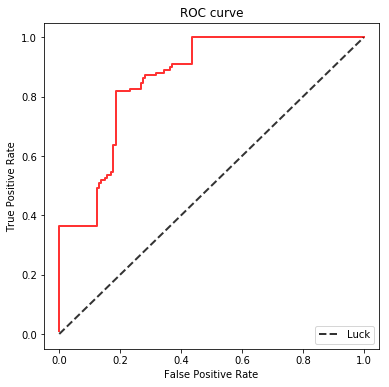

In [373]:
fig = plt.figure(figsize=(6, 6))
fpr, tpr, _ = roc_curve(y, y_score)
auc = roc_auc_score(y, y_score)
print(auc)
plt.plot(fpr, tpr, lw=2, c='r', alpha=0.8)#, label = r'%s (AUC = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='black', label='Luck', alpha=.8)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC curve")
plt.legend(loc="lower right")
plt.show()

In [255]:
np.mean(((y_score>.5) * y) + ((y_score<.5) * (1 - y)))

0.7222222222222222

Split for cross-validation

In [392]:
y_trues, y_scores = [], []

sss = StratifiedShuffleSplit(n_splits=3, test_size=0.5)
sss.get_n_splits(df_combined.index.get_level_values(0).unique(), df_combined.ytrue.groupby(level=0).first())
for train_index, test_index in kf.split(df_combined.index.get_level_values(0).unique(), df_combined.ytrue.groupby(level=0).first()):
    X_train = df_combined.loc(axis=0)[train_index, :].drop("ytrue", axis=1).values
    X_test = df_combined.loc(axis=0)[test_index, :].drop("ytrue", axis=1).values

    y_train = df_combined.loc(axis=0)[train_index, :]["ytrue"].values
    y_test = df_combined.loc(axis=0)[test_index, :]["ytrue"].values

    r = LogisticRegression(class_weight='balanced')
    r.fit(X_train, y_train)
    y_score = r.predict_proba(X_test)

    y_trues.extend(y_test)
    y_scores.extend(y_score[:, 1])

0.44249999999999995


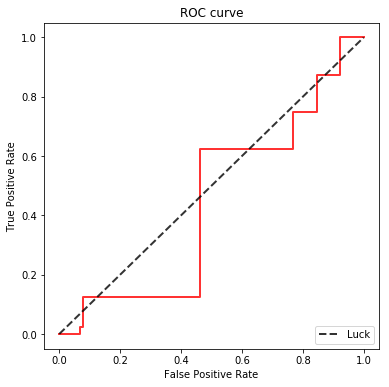

In [393]:
fig = plt.figure(figsize=(6, 6))
fpr, tpr, _ = roc_curve(y_trues, y_scores)
auc = roc_auc_score(y_trues, y_scores)
print(auc)
plt.plot(fpr, tpr, lw=2, c='r', alpha=0.8)#, label = r'%s (AUC = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='black', label='Luck', alpha=.8)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC curve")
plt.legend(loc="lower right")
plt.show()

Grid for best L2 reg parameter

In [398]:
aucs = []
ls = np.logspace(-3, 3, num=60)
for l in ls:
    print(l)
    y_trues, y_scores = [], []

    sss = StratifiedShuffleSplit(n_splits=3, test_size=0.5)
    sss.get_n_splits(df_combined.index.get_level_values(0).unique(), df_combined.ytrue.groupby(level=0).first())
    for train_index, test_index in kf.split(df_combined.index.get_level_values(0).unique(), df_combined.ytrue.groupby(level=0).first()):
        X_train = df_combined.loc(axis=0)[train_index, :].drop("ytrue", axis=1).values
        X_test = df_combined.loc(axis=0)[test_index, :].drop("ytrue", axis=1).values

        y_train = df_combined.loc(axis=0)[train_index, :]["ytrue"].values
        y_test = df_combined.loc(axis=0)[test_index, :]["ytrue"].values

        r = LogisticRegression(class_weight='balanced', C=l, penalty='l2')
        r.fit(X_train, y_train)
        y_score = r.predict_proba(X_test)

        y_trues.extend(y_test)
        y_scores.extend(y_score[:, 1])

    auc = roc_auc_score(y_trues, y_scores)
    aucs.append(auc)

0.001
0.0012638482029342984
0.001597312280060254
0.002018760254679039
0.0025514065200312875
0.0032245905452963947
0.004075392965871778
0.005150678076168122
0.00650967523045817
0.008227241341700473
0.0103979841848149
0.013141473626117567
0.016608827826277157
0.020991037201085545
0.026529484644318972
0.03352924149249558
0.04237587160604064
0.05355666917706899
0.06768750009458535
0.08554672535565684
0.10811807510766078
0.13664483492953258
0.1726983290659436
0.21826447283974873
0.2758531617629184
0.34863652276780877
0.44062364277735727
0.5568813990945273
0.7038135554931562
0.8895134973108236
1.1242100350620874
1.4208308325339223
1.795714494371641
2.269510536694671
2.868316813342012
3.6251170499885355
4.581597669054491
5.790443980602489
7.318242219076182
9.249147277217336
11.689518164985776
14.773776525985127
18.671810912919206
23.598334667821938
29.82471286216894
37.69390975388364
47.639380104013405
60.20894493336138
76.09496685459884
96.17248711152965
121.54742500762885
153.61749466718297

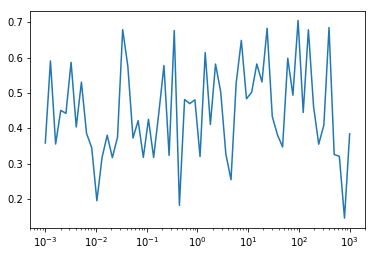

In [399]:
plt.plot(ls, aucs)
plt.xscale("log")

In [400]:
aucs = []
ls = np.logspace(-3, 3, num=60)
for l in ls:
    print(l)
    y_trues, y_scores = [], []

    sss = StratifiedShuffleSplit(n_splits=3, test_size=0.5)
    sss.get_n_splits(df_combined.index.get_level_values(0).unique(), df_combined.ytrue.groupby(level=0).first())
    for train_index, test_index in kf.split(df_combined.index.get_level_values(0).unique(), df_combined.ytrue.groupby(level=0).first()):
        X_train = df_combined.loc(axis=0)[train_index, :].drop("ytrue", axis=1).values
        X_test = df_combined.loc(axis=0)[test_index, :].drop("ytrue", axis=1).values

        y_train = df_combined.loc(axis=0)[train_index, :]["ytrue"].values
        y_test = df_combined.loc(axis=0)[test_index, :]["ytrue"].values

        r = LogisticRegression(class_weight='balanced', C=l, penalty='l1')
        r.fit(X_train, y_train)
        y_score = r.predict_proba(X_test)

        y_trues.extend(y_test)
        y_scores.extend(y_score[:, 1])

    auc = roc_auc_score(y_trues, y_scores)
    aucs.append(auc)

0.001
0.0012638482029342984
0.001597312280060254
0.002018760254679039
0.0025514065200312875
0.0032245905452963947
0.004075392965871778
0.005150678076168122
0.00650967523045817
0.008227241341700473
0.0103979841848149
0.013141473626117567
0.016608827826277157
0.020991037201085545
0.026529484644318972
0.03352924149249558
0.04237587160604064
0.05355666917706899
0.06768750009458535
0.08554672535565684
0.10811807510766078
0.13664483492953258
0.1726983290659436
0.21826447283974873
0.2758531617629184
0.34863652276780877
0.44062364277735727
0.5568813990945273
0.7038135554931562
0.8895134973108236
1.1242100350620874
1.4208308325339223
1.795714494371641
2.269510536694671
2.868316813342012
3.6251170499885355
4.581597669054491
5.790443980602489
7.318242219076182
9.249147277217336
11.689518164985776
14.773776525985127
18.671810912919206
23.598334667821938
29.82471286216894
37.69390975388364
47.639380104013405
60.20894493336138
76.09496685459884
96.17248711152965
121.54742500762885
153.61749466718297

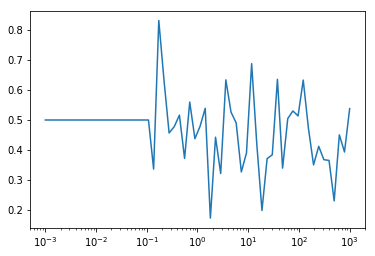

In [401]:
plt.plot(ls, aucs)
plt.xscale("log")

Features overfit

In [443]:
y_trues, y_scores = [], []
cc = []

sss = KFold(n_splits=3, shuffle=True)
for train_index, test_index in sss.split(df_patho.index):
    X_train = df_patho.iloc[train_index, :].values
    X_test = df_patho.iloc[test_index, :].values

    y_train = df_patho.iloc[train_index, :].index.get_level_values(0) - 1
    y_test = df_patho.iloc[test_index, :].index.get_level_values(0) - 1

    r = LogisticRegression(class_weight='balanced')
    r.fit(X_train, y_train)
    y_score = r.predict_proba(X_test)

    y_trues.extend(y_test)
    y_scores.extend(y_score[range(y_test.shape[0]), y_test])
    cc.extend(np.argmax(y_score, axis=1) == y_test)

In [438]:
np.mean(y_scores)

0.11807512403640419

In [444]:
np.mean(cc)

0.56875